# Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
import json
import sys
import requests
import warnings
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
with open('data/modeling_data.pkl', 'rb') as f:
    df = pkl.load(f)

# Bernoulli NB Model

## Modeling on all features

In [3]:
X = df.drop('delayed_2',axis=1)
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## First gridsearch with different PCA levels and different alphas

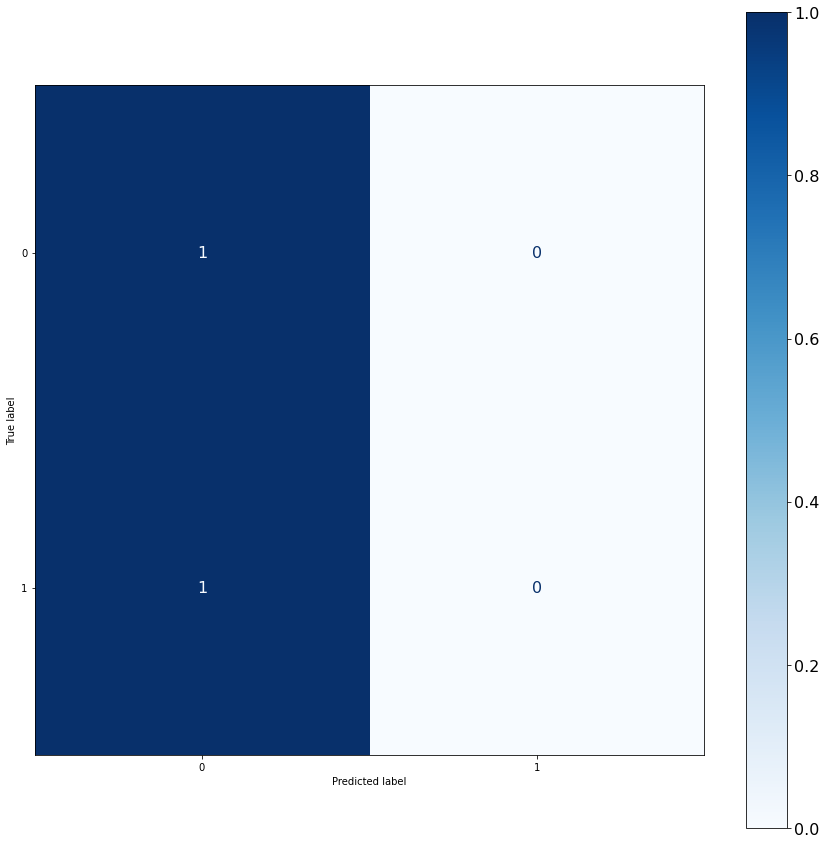

Pipeline(steps=[('pca', PCA(n_components=0.7)), ('bnb', BernoulliNB(alpha=1))])
0.6649070233582727
0.513302395295881


In [4]:
parameters = {'pca__n_components':[.7,.8,.9,.95],'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('pca', PCA()),('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

# determining our y_pred
y_pred = cross_val_predict(pipe, X_train, y_train)

# plotting confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

This isn't predicting the true class at all. Let's test without PCA

## GSV without PCA

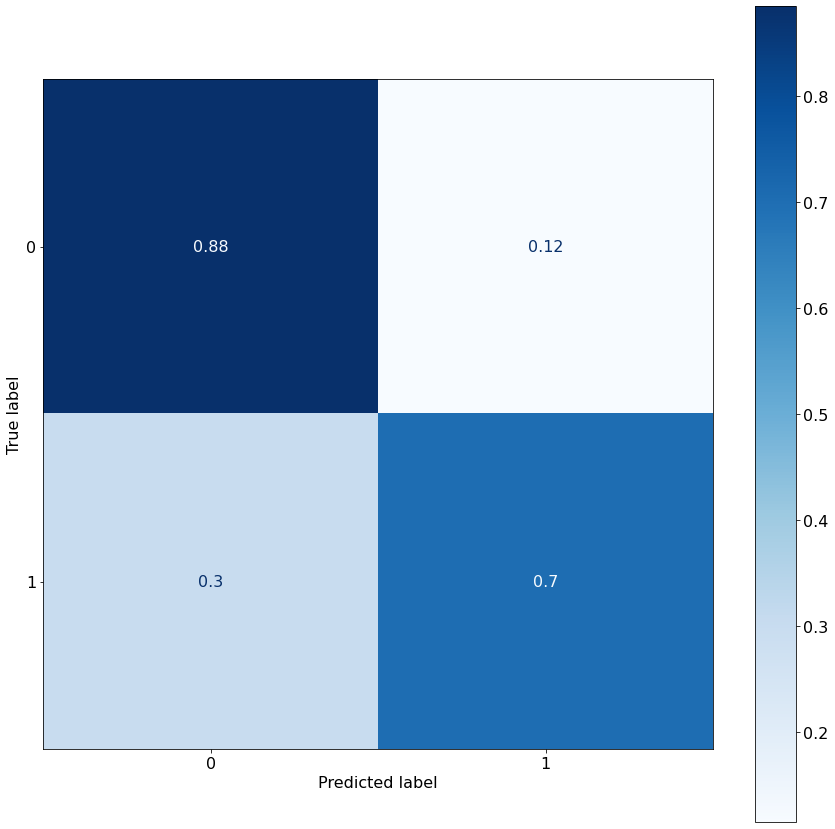

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.8230764651015102
0.7264246478657134


In [5]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

PCA was clearly an issue and we know that, overall, an alpha of 1 is best.

Let's keep exploring with subsets of the data.

# Exploring subsets

## Location and direction as predictors

In [6]:
X = df[['bronx','brooklyn','manhattan','queens','direction_both',
        'direction_manhattan', 'direction_northbound', 'direction_southbound']]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

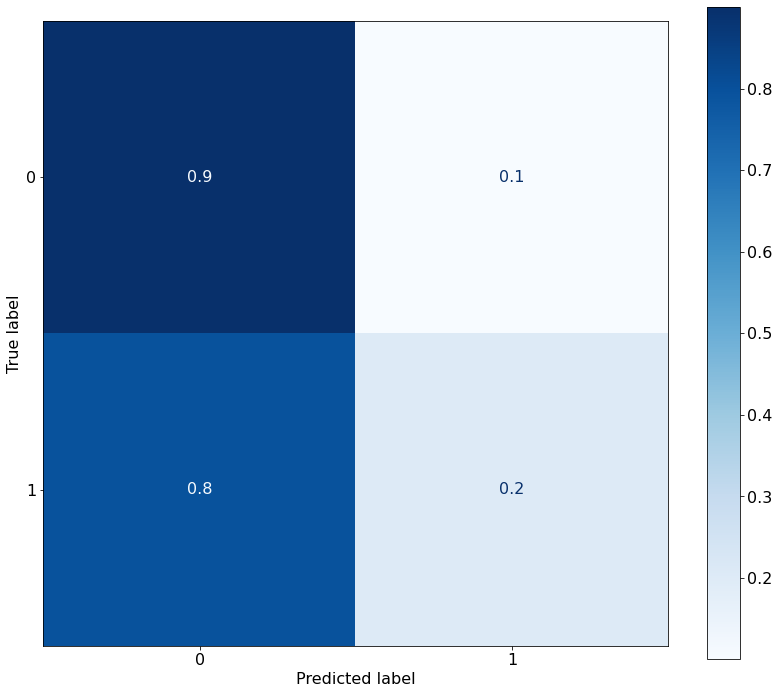

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.6670900394927465
0.3041440245571826


In [7]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

Location and direction are not good predictors

## Weather condition a predictor

In [8]:
X = df[['major_conditions','minor_conditions', 'neutral_conditions', 'clear_conditions','max_temp',
        'avg_temp', 'min_temp', 'avg_wind_spd','prcp', 'snowfall', 'snowfall_depth', 'fastest_wind_spd']]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

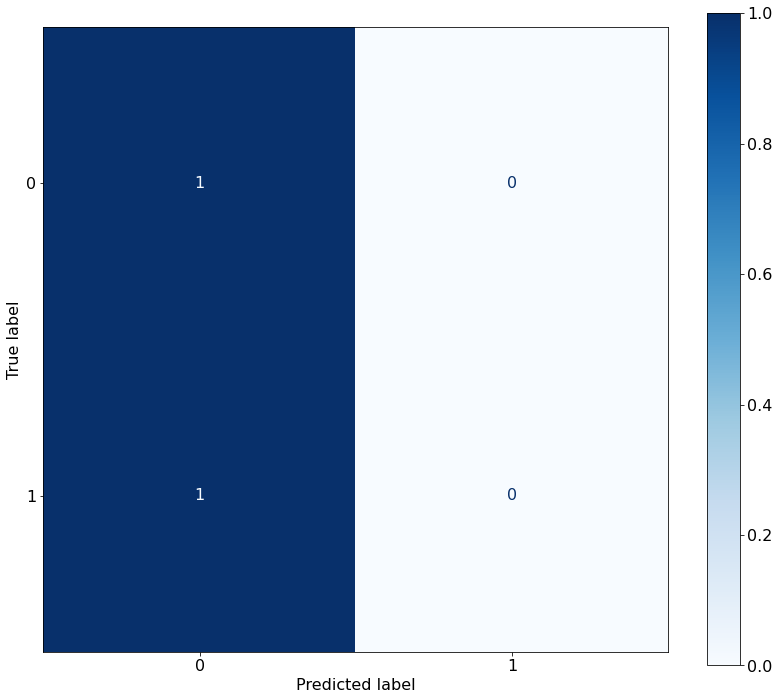

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.6652443985790549
0.0


In [9]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

Well, this is awful. What else?

## Time as predictor

In [10]:
features = ['major_conditions', 'minor_conditions','neutral_conditions', 'clear_conditions', 
            'max_temp', 'avg_temp', 'min_temp', 'avg_wind_spd', 'prcp', 'snowfall', 'snowfall_depth',
            'fastest_wind_spd','bronx', 'brooklyn', 'manhattan', 'queens', 'causes_conditions',
            'causes_passenger', 'causes_station', 'causes_train', 'direction_both', 'direction_manhattan',
            'direction_northbound', 'rush_hour','direction_southbound']

In [11]:
time_features = ['mon', 'tue', 'wed', 'th', 'fri', 'sat','sun']

In [12]:
i = 1
time_list = []
for time in time_features:
    X = df[features]
    y = df[time]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
    pipe = Pipeline(steps=[('bnb',BernoulliNB())])
    gsv = GridSearchCV(pipe, parameters,scoring='f1')
    gsv.fit(X_train, y_train)
    
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    acc_sc = round(accuracy_score(y_train,y_pred), 3)
    f1_sc = round(f1_score(y_train, y_pred), 3)
    best_est = gsv.best_estimator_
    
#     print(f"""
#     station number: {i}
#     station name: {station}
#     f1 score: {f1_sc}""")
    
#     print("""
    
#     """)
    
    time_dict = {}
    
    time_dict['number'] = i
    time_dict['time'] = time
    time_dict['best_gsv_estimator'] = best_est
    time_dict['acc_score'] = acc_sc
    time_dict['f1_sc'] = f1_sc
    
    time_list.append(time_dict)
        
    i += 1

maxAccscore = max(time_list, key=lambda x:x['acc_score'])
maxF1score = max(time_list, key=lambda x:x['f1_sc'])

print(f"""
Cause with highest Accuracy Score: {maxAccscore['time']}
Accuracy Score: {maxAccscore['acc_score']}\n\n
Cause with highest F1 Score: {maxF1score['time']}
F1 Score: {maxF1score['f1_sc']}""")


Cause with highest Accuracy Score: sun
Accuracy Score: 0.906


Cause with highest F1 Score: sun
F1 Score: 0.008


In [13]:
X = df[['mon', 'tue', 'wed', 'th', 'fri', 'sat','sun']]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

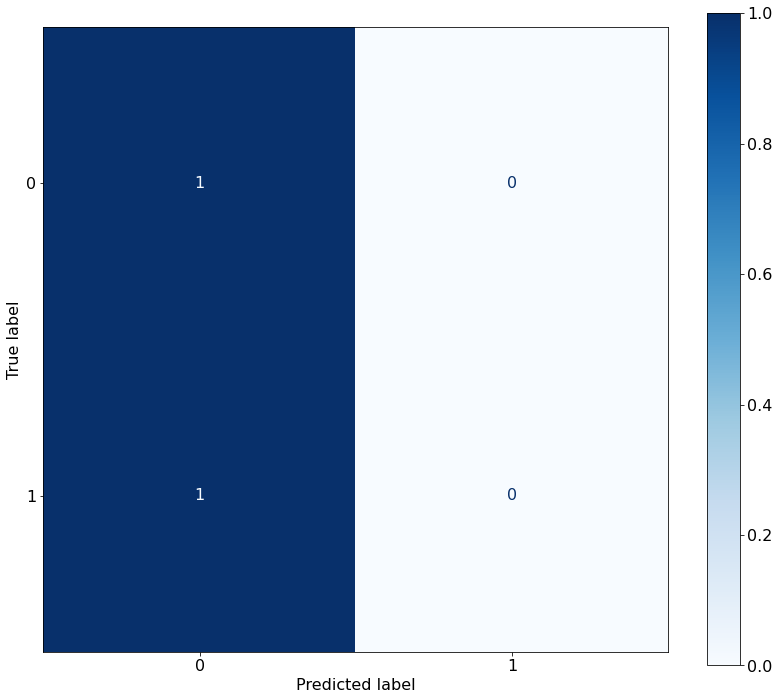

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.6652840897814999
0.0


In [14]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

Nothing much here, though Sunday seems to be the strongest predictor.

## Causes as a predictor

In [15]:
features = ['rush_hour', 'weekend', 'major_conditions', 'minor_conditions',
            'neutral_conditions', 'clear_conditions', 'mon', 'tue', 'wed', 'th', 'fri', 'sat', 'sun',
            'max_temp', 'avg_temp', 'min_temp', 'avg_wind_spd', 'prcp', 'snowfall', 'snowfall_depth',
            'fastest_wind_spd','bronx', 'brooklyn', 'manhattan', 'queens', 'direction_both', 'direction_manhattan',
            'direction_northbound', 'direction_southbound']

In [16]:
causes_features = ['causes_conditions', 'causes_passenger', 'causes_station', 'causes_train']

In [17]:
i = 1
causes = []
for cause in causes_features:
    X = df[features]
    y = df[cause]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
    pipe = Pipeline(steps=[('bnb',BernoulliNB())])
    gsv = GridSearchCV(pipe, parameters,scoring='f1')
    gsv.fit(X_train, y_train)
    
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    acc_sc = round(accuracy_score(y_train,y_pred), 3)
    f1_sc = round(f1_score(y_train, y_pred), 3)
    best_est = gsv.best_estimator_
    
#     print(f"""
#     station number: {i}
#     station name: {station}
#     f1 score: {f1_sc}""")
    
#     print("""
    
#     """)
    
    cause_dict = {}
    
    cause_dict['number'] = i
    cause_dict['cause_name'] = cause
    cause_dict['best_gsv_estimator'] = best_est
    cause_dict['acc_score'] = acc_sc
    cause_dict['f1_sc'] = f1_sc
    
    causes.append(cause_dict)
        
    i += 1

maxAccscore = max(causes, key=lambda x:x['acc_score'])
maxF1score = max(causes, key=lambda x:x['f1_sc'])

print(f"""
Cause with highest Accuracy Score: {maxAccscore['cause_name']}
Accuracy Score: {maxAccscore['acc_score']}\n\n
Cause with highest F1 Score: {maxF1score['cause_name']}
F1 Score: {maxF1score['f1_sc']}""")


Cause with highest Accuracy Score: causes_conditions
Accuracy Score: 0.955


Cause with highest F1 Score: causes_station
F1 Score: 0.193


In [18]:
X = df[['causes_conditions', 'causes_passenger', 'causes_station', 'causes_train']]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

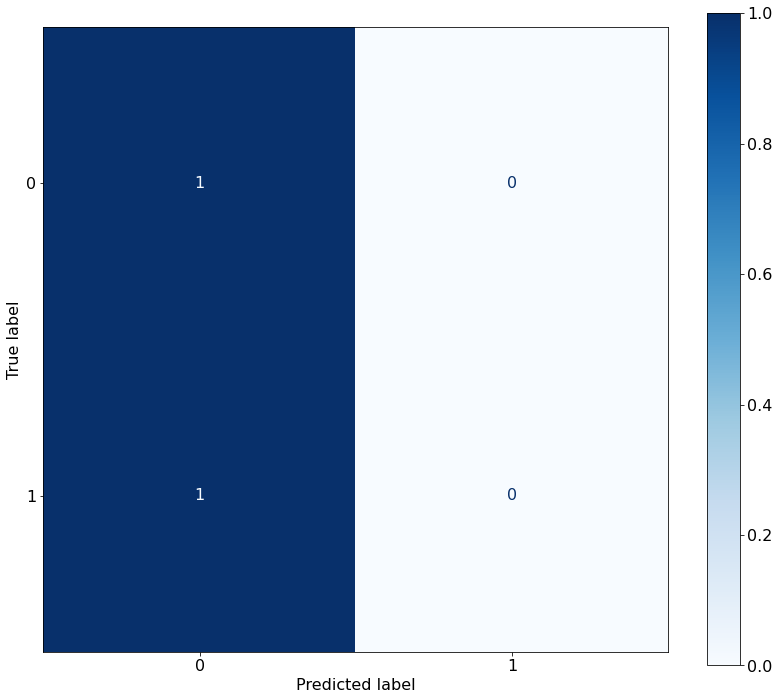

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.6652840897814999
0.0


In [19]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

Nothin' doing here, but causes_station has the best f1 score, so we press on.

# Stations

## Inspecting each station series

In [20]:
bronx_2_stations = ['wakefield-241 st (2/5)','nereid av (2/5)','233 st (2/5)','225 st (2/5)','219 st (2/5)',
                   'gun hill rd (2/5)','burke av (2/5)','allerton av (2/5)','pelham pkwy (2/5)','bronx park east (2/5)',
                   'e 180 st (2/5)','west farm sq (2/5)','174 st (2/5)','freeman st (2/5)','simpson st (2/5)',
                    'intervale av (2/5)','prospect av (2/5)','jackson av (2/5)','3 av-149 st (2/5)','149 st-grand concourse (2/4/5)'
                   ]
manh_2_stations = ['135 st (2/3)','125 st (1/2/3)','116 st (2/3)','central park n-110 st (2/3)','96 st (1/2/3)',
                  '72 st (1/2/3)',  '42 st-times sq (1/2/3/7/S)','34 st-penn st (1/2/3)', '14 st-7 av (1/2/3)',
                  'chambers st (1/2/3)','park pl (2/3)','fulton st (2/3)','wall st (2/3)']
bk_2_stations = ['clark st (2/3)','borough hall (2/3/4/5)','hoyt st (2/3)','nevins st (2/3/4/5)',
                'atlantic av-barclays ctr (2/3/4/5)','bergen st (2/3)','grand army plza (2/3)','eastern pkwy (2/3)',
                'franklin av-medgar evers clg (2/3/4/5)','president st-medgar evers clg (2/5)', 'sterling st (2/5)',
                'winthrop st (2/5)','church av (2/5)', 'beverly rd (2/5)','newkirk av (2/5)','flatbush av-bk clg (2/5)']

## The Bronx

In [21]:
X = df[bronx_2_stations]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

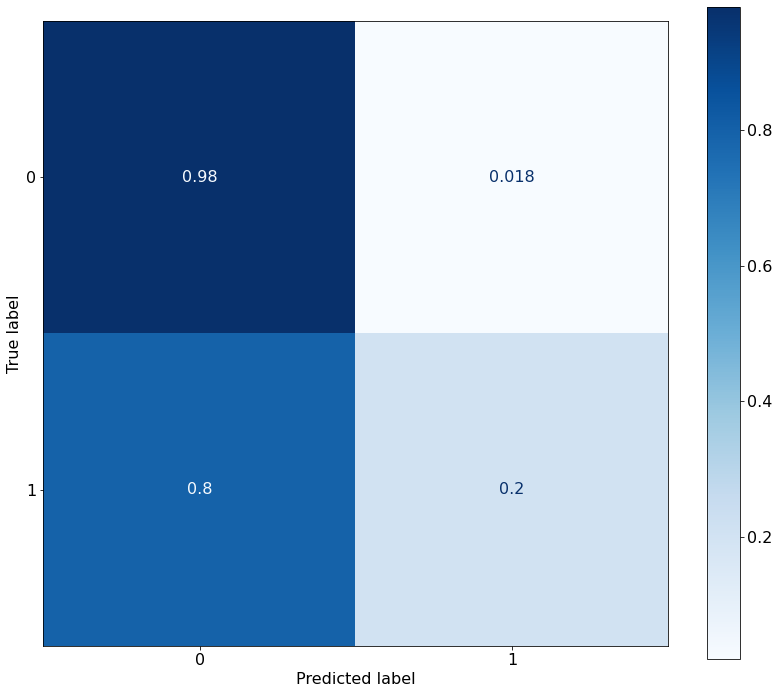

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.720276250769017
0.3242724962845774


In [22]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

## Brooklyn

In [23]:
X = df[bk_2_stations]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

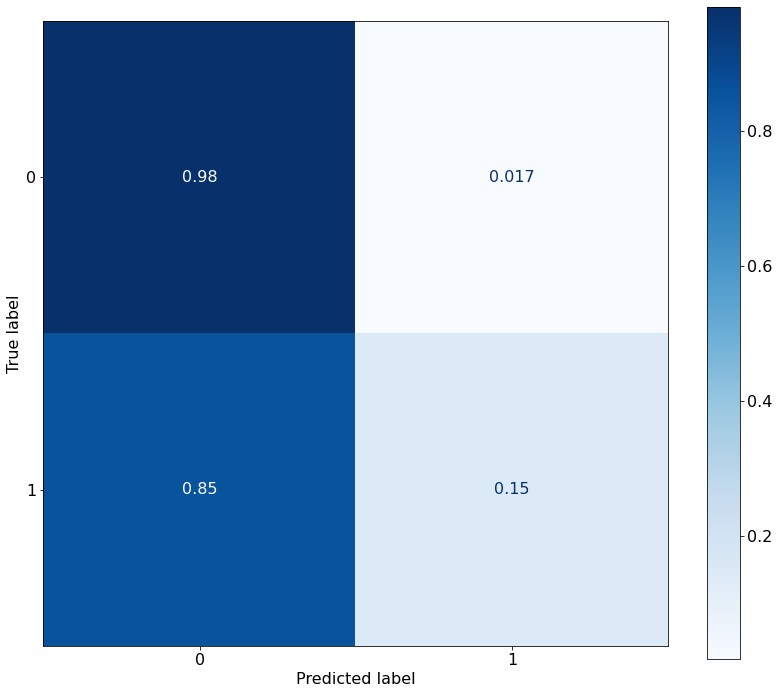

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.7036853281470162
0.2508654859264462


In [24]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

## Manhattan

In [25]:
X = df[manh_2_stations]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

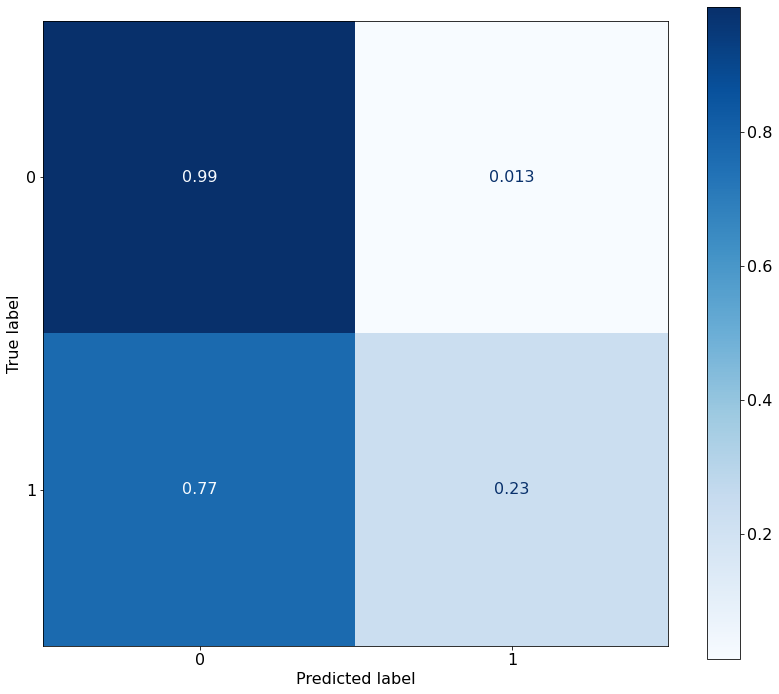

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.7336124947905297
0.36633149223433886


In [26]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

None of these are particularly good predictors on their own.

## All stations

In [27]:
X = df[bronx_2_stations+bk_2_stations+manh_2_stations]
y = df['delayed_2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

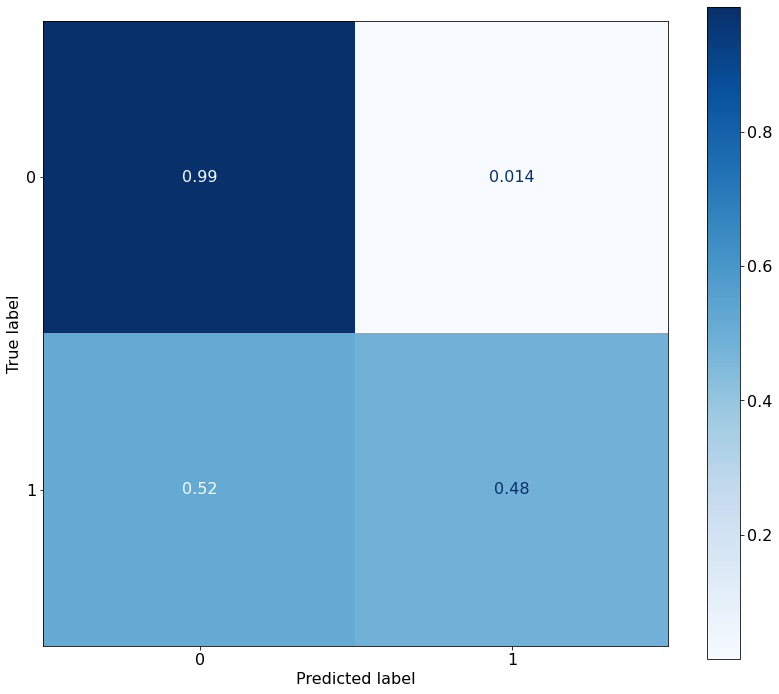

Pipeline(steps=[('bnb', BernoulliNB(alpha=1))])
0.8196828672924646
0.649297514281303


In [28]:
parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe = Pipeline(steps=[('bnb',BernoulliNB())])
gsv = GridSearchCV(pipe, parameters,scoring='accuracy')
gsv.fit(X_train, y_train)

y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)

fig, ax = plt.subplots(figsize=(14, 12))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv.best_estimator_, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

# checking the best estimators from gsv
print(gsv.best_estimator_)

# checking accuracy and f1 scores
print(accuracy_score(y_train,y_pred))
print(f1_score(y_train, y_pred))

Well, this is getting *somewhere*, thankfully!

# Stations as target

## Setting all features

In [29]:
features = ['rush_hour', 'weekend', 'major_conditions', 'minor_conditions',
            'neutral_conditions', 'clear_conditions', 'mon', 'tue', 'wed', 'th', 'fri', 'sat', 'sun',
            'max_temp', 'avg_temp', 'min_temp', 'avg_wind_spd', 'prcp', 'snowfall', 'snowfall_depth',
            'fastest_wind_spd','bronx', 'brooklyn', 'manhattan', 'queens', 'causes_conditions',
            'causes_passenger', 'causes_station', 'causes_train', 'direction_both', 'direction_manhattan',
            'direction_northbound', 'direction_southbound']

## The Bronx

In [30]:
bronx_2_stations

['wakefield-241 st (2/5)',
 'nereid av (2/5)',
 '233 st (2/5)',
 '225 st (2/5)',
 '219 st (2/5)',
 'gun hill rd (2/5)',
 'burke av (2/5)',
 'allerton av (2/5)',
 'pelham pkwy (2/5)',
 'bronx park east (2/5)',
 'e 180 st (2/5)',
 'west farm sq (2/5)',
 '174 st (2/5)',
 'freeman st (2/5)',
 'simpson st (2/5)',
 'intervale av (2/5)',
 'prospect av (2/5)',
 'jackson av (2/5)',
 '3 av-149 st (2/5)',
 '149 st-grand concourse (2/4/5)']

In [31]:
i = 1
bronx_stations = []
for station in bronx_2_stations:
    X = df[features]
    y = df[station]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
    pipe = Pipeline(steps=[('bnb',BernoulliNB())])
    gsv = GridSearchCV(pipe, parameters,scoring='f1')
    gsv.fit(X_train, y_train)
    
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    acc_sc = round(accuracy_score(y_train,y_pred), 3)
    f1_sc = round(f1_score(y_train, y_pred), 3)
    best_est = gsv.best_estimator_
    
#     print(f"""
#     station number: {i}
#     station name: {station}
#     f1 score: {f1_sc}""")
    
#     print("""
    
#     """)
    
    bronx_dict = {}
    
    bronx_dict['number'] = i
    bronx_dict['station_name'] = station
    bronx_dict['best_gsv_estimator'] = best_est
    bronx_dict['acc_score'] = acc_sc
    bronx_dict['f1_sc'] = f1_sc
    
    bronx_stations.append(bronx_dict)
        
    i += 1

maxAccscore = max(bronx_stations, key=lambda x:x['acc_score'])
maxF1score = max(bronx_stations, key=lambda x:x['f1_sc'])

print(f"""
Station with highest Accuracy Score: {maxAccscore['station_name']}
Accuracy Score: {maxAccscore['acc_score']}\n\n
Station with highest F1 Score: {maxF1score['station_name']}
F1 Score: {maxF1score['f1_sc']}""")


Station with highest Accuracy Score: 233 st (2/5)
Accuracy Score: 0.999


Station with highest F1 Score: e 180 st (2/5)
F1 Score: 0.006


## Brooklyn

In [32]:
bk_2_stations

['clark st (2/3)',
 'borough hall (2/3/4/5)',
 'hoyt st (2/3)',
 'nevins st (2/3/4/5)',
 'atlantic av-barclays ctr (2/3/4/5)',
 'bergen st (2/3)',
 'grand army plza (2/3)',
 'eastern pkwy (2/3)',
 'franklin av-medgar evers clg (2/3/4/5)',
 'president st-medgar evers clg (2/5)',
 'sterling st (2/5)',
 'winthrop st (2/5)',
 'church av (2/5)',
 'beverly rd (2/5)',
 'newkirk av (2/5)',
 'flatbush av-bk clg (2/5)']

In [33]:
i = 1
bk_stations = []
for station in bk_2_stations:
    X = df[features]
    y = df[station]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
    pipe = Pipeline(steps=[('bnb',BernoulliNB())])
    gsv = GridSearchCV(pipe, parameters,scoring='f1')
    gsv.fit(X_train, y_train)
    
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    acc_sc = round(accuracy_score(y_train,y_pred), 3)
    f1_sc = round(f1_score(y_train, y_pred), 3)
    best_est = gsv.best_estimator_
    
#     print(f"""
#     station number: {i}
#     station name: {station}
#     f1 score: {f1_sc}""")
    
#     print("""
    
#     """)
    
    bk_dict = {}
    
    bk_dict['number'] = i
    bk_dict['station_name'] = station
    bk_dict['best_gsv_estimator'] = best_est
    bk_dict['acc_score'] = acc_sc
    bk_dict['f1_sc'] = f1_sc
    
    bk_stations.append(bk_dict)
        
    i += 1

maxAccscore = max(bk_stations, key=lambda x:x['acc_score'])
maxF1score = max(bk_stations, key=lambda x:x['f1_sc'])

print(f"""
Station with highest Accuracy Score: {maxAccscore['station_name']}
Accuracy Score: {maxAccscore['acc_score']}\n\n
Station with highest F1 Score: {maxF1score['station_name']}
F1 Score: {maxF1score['f1_sc']}""")


Station with highest Accuracy Score: beverly rd (2/5)
Accuracy Score: 0.999


Station with highest F1 Score: flatbush av-bk clg (2/5)
F1 Score: 0.203


## Manhattan

In [34]:
manh_2_stations

['135 st (2/3)',
 '125 st (1/2/3)',
 '116 st (2/3)',
 'central park n-110 st (2/3)',
 '96 st (1/2/3)',
 '72 st (1/2/3)',
 '42 st-times sq (1/2/3/7/S)',
 '34 st-penn st (1/2/3)',
 '14 st-7 av (1/2/3)',
 'chambers st (1/2/3)',
 'park pl (2/3)',
 'fulton st (2/3)',
 'wall st (2/3)']

In [35]:
i = 1
manh_stations = []
for station in manh_2_stations:
    X = df[features]
    y = df[station]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
    pipe = Pipeline(steps=[('bnb',BernoulliNB())])
    gsv = GridSearchCV(pipe, parameters,scoring='f1')
    gsv.fit(X_train, y_train)
    
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    acc_sc = round(accuracy_score(y_train,y_pred), 3)
    f1_sc = round(f1_score(y_train, y_pred), 3)
    best_est = gsv.best_estimator_
    
#     print(f"""
#     station number: {i}
#     station name: {station}
#     f1 score: {f1_sc}""")
    
#     print("""
    
#     """)
    
    manh_dict = {}
    
    manh_dict['number'] = i
    manh_dict['station_name'] = station
    manh_dict['best_gsv_estimator'] = best_est
    manh_dict['acc_score'] = acc_sc
    manh_dict['f1_sc'] = f1_sc
    
    manh_stations.append(manh_dict)
        
    i += 1

maxAccscore = max(manh_stations, key=lambda x:x['acc_score'])
maxF1score = max(manh_stations, key=lambda x:x['f1_sc'])

print(f"""
Station with highest Accuracy Score: {maxAccscore['station_name']}
Accuracy Score: {maxAccscore['acc_score']}\n\n
Station with highest F1 Score: {maxF1score['station_name']}
F1 Score: {maxF1score['f1_sc']}""")


Station with highest Accuracy Score: park pl (2/3)
Accuracy Score: 0.997


Station with highest F1 Score: 135 st (2/3)
F1 Score: 0.0


## All stations

This is all fairly inconclusive. Let's put all the stations in one and see if we can predict delays at them.

In [36]:
all_2_stations = bronx_2_stations+manh_2_stations+bk_2_stations

In [37]:
i = 1
all_stations = []
for station in all_2_stations:
    X = df[features]
    y = df[station]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    parameters = {'bnb__alpha':[1,.9,.5,.2,0]}
    pipe = Pipeline(steps=[('bnb',BernoulliNB())])
    gsv = GridSearchCV(pipe, parameters,scoring='f1')
    gsv.fit(X_train, y_train)
    
    y_pred = cross_val_predict(pipe, X_train, y_train, cv=5)
    acc_sc = round(accuracy_score(y_train,y_pred), 3)
    f1_sc = round(f1_score(y_train, y_pred), 3)
    best_est = gsv.best_estimator_
    
#     print(f"""
#     station number: {i}
#     station name: {station}
#     f1 score: {f1_sc}""")
    
#     print("""
    
#     """)
    
    all_dict = {}
    
    all_dict['number'] = i
    all_dict['station_name'] = station
    all_dict['best_gsv_estimator'] = best_est
    all_dict['acc_score'] = acc_sc
    all_dict['f1_sc'] = f1_sc
    
    all_stations.append(all_dict)
        
    i += 1

maxAccscore = max(all_stations, key=lambda x:x['acc_score'])
maxF1score = max(all_stations, key=lambda x:x['f1_sc'])

print(f"""
Station with highest Accuracy Score: {maxAccscore['station_name']}
Accuracy Score: {maxAccscore['acc_score']}\n\n
Station with highest F1 Score: {maxF1score['station_name']}
F1 Score: {maxF1score['f1_sc']}""")


Station with highest Accuracy Score: 233 st (2/5)
Accuracy Score: 0.999


Station with highest F1 Score: flatbush av-bk clg (2/5)
F1 Score: 0.203


So we can see that Flatbush Av - Brooklyn College is the station that most significantly causes delays on the 2 line.

Coupled with Brooklyn being the borough with the higheste delay percentage, we start to get a feel for what's going on here.